In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#### Funções

In [2]:
def centralizar(train_df, test_df):
    medias = train_df.mean()
    train_centralizado = train_df - medias
    test_centralizado = test_df - medias
    train = np.asarray(train_centralizado)
    test = np.asarray(test_centralizado)
    return train, test 

def decomposicao_svd(df):
    U, S, Vt = np.linalg.svd(df, full_matrices=False)
    return U, S, Vt

def grafico_variabilidade(variabilidade, S):
    plt.plot(range(1, len(variabilidade) + 1), variabilidade, marker='o', markersize=1, markerfacecolor='teal', markeredgecolor='teal', color='darkturquoise')
    plt.xlabel('Número de Valores Singulares')
    plt.ylabel('Variabilidade Acumulada')
    plt.title('Valores Singulares por Variabilidade Acumulada')
    plt.grid(color='lightgray', alpha=0.7)
    plt.show()

def componentes_principais(r, Vt, train, test):
    Vt_reduced = Vt[:r, :]

    P_train = np.dot(train, Vt_reduced.T)
    P_test = np.dot(test, Vt_reduced.T)
    return P_train, P_test

def calculo_rmse(result, y_test):
    diff = (np.array(result) - np.array(y_test)) ** 2

    mean_diff = np.mean(diff)

    rmse = np.sqrt(mean_diff)

    return rmse

def euclidian_distance(x, y):
    len_x = len(x)
    len_y = len(y)
    if (len_x < len_y):
        x.resize(len_y, refcheck=False)
        x[len_x:(len_y-1)] = 0
    elif (len_y < len_x):
        y.resize(len_x, refcheck=False)
        y[len_y:(len_x-1)] = 0
    if (len(x) == len(y)):
        diff = 0
        for index, value_x in enumerate(x):
            diff+=(value_x-y[index])*(value_x-y[index])
        return np.sqrt(diff)
    else:
        print("Não foi possível calcular a distância euclidiana")
        return
    
def knn(X_train, X_test, y_train, y_test):
    start_time = time.time()
    classes_prediction = []
    for test_vector in X_test:
        distances_classes = []
        for index, train_vector in enumerate(X_train):
            dist = euclidian_distance(train_vector, test_vector)
            distances_classes.append((dist, y_train[index]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    end_time = time.time()
    total_time_seconds = end_time - start_time
    hours, remainder = divmod(total_time_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    print(f"Tempo de execução: {int(hours)} horas, {int(minutes)} minutos e {seconds:.6f} segundos")
    
    return classes_prediction, total_time_seconds

def calcular_acuracia(y_train, y_predicted):

    assert len(y_train) == len(y_predicted), "Os arrays devem ter o mesmo tamanho"
    
    acertos = sum(1 for real, predito in zip(y_train, y_predicted) if real == predito)
    
    acuracia = (acertos / len(y_train)) * 100
    
    return acuracia
        

#### Sign Language Mnist Dataset 
O dataset é o mesmo utilizado no trabalho 1, e consiste em + 34 mil fotos de mãos realizando as letras do alfabeto de linguagem de sinais americano com seus respectivos identificadores (número de 1-25, indicando a letra). Cada imagem contem _784_ pixels, que é representado por um número de 0-255, que representa a cor daquele pixel.
Os dados vêm divididos em: dados de treino (com _27454_ amostras) e dados de teste (com _7171_ amostras), totalizando _34625_ amostras. 

Essa letra é represenada por: 18


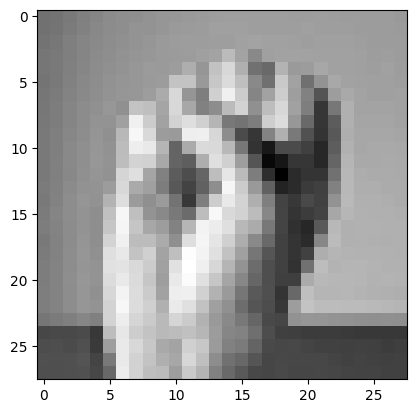

In [27]:
example = pd.read_csv("../knn/sign_mnist_train.csv")
rotulo = example['label'].iloc[10]
print(f'Essa letra é represenada por: {rotulo}')
example.drop(columns=['label'], inplace=True)
img = np.asarray(example.iloc[10])
img = img.reshape((28, 28))
plt.imshow(img, cmap="gray")
plt.show()

In [5]:
train = pd.read_csv("../knn/sign_mnist_train.csv")

train.shape

(27455, 785)

In [6]:
test = pd.read_csv("../knn/sign_mnist_test.csv")

test.shape

(7172, 785)

In [7]:
y_train_arr = np.asarray(train['label'])
y_test_arr = np.asarray(test['label'])

In [8]:
test.drop(columns=['label'], inplace=True)
train.drop(columns=['label'],inplace=True)

#### Centralização dos dados
Para a centralização dos dados, foi calculado a média das colunas do dataset de treino e depois essa média foi subtraída dos datasets de treino e de teste.

In [9]:
train, test = centralizar(train, test)

In [31]:
print(f'Dataset de treino centralizado: \n{train}\n-----------------\nDataset de teste centralizado: \n{test}')

Dataset de treino centralizado: 
[[-38.41937716 -30.50027317 -24.24771444 ...  42.0335458   41.86210162
   42.17526862]
 [  9.58062284   8.49972683   4.75228556 ... -58.9664542  -26.13789838
  -10.82473138]
 [ 41.58062284  39.49972683  36.75228556 ...  33.0335458   32.86210162
   35.17526862]
 ...
 [ 28.58062284  25.49972683  22.75228556 ...  40.0335458   38.86210162
   40.17526862]
 [ 31.58062284  32.49972683  32.75228556 ... -97.9664542  -74.13789838
  -66.82473138]
 [ 33.58062284  31.49972683  28.75228556 ...  43.0335458   47.86210162
   55.17526862]]
-----------------
Dataset de teste centralizado: 
[[  3.58062284   0.49972683  -1.24771444 ... -49.9664542  -41.13789838
  -52.82473138]
 [-19.41937716 -20.50027317 -20.24771444 ...  22.0335458   20.86210162
   20.17526862]
 [-60.41937716 -60.50027317 -59.24771444 ...  63.0335458   62.86210162
   62.17526862]
 ...
 [ 44.58062284  42.49972683  38.75228556 ...  49.0335458   47.86210162
   48.17526862]
 [ 55.58062284  56.49972683  56.7522

#### Decomposição SVD
Foi realizado com o método ```np.linalg.svd``` com o parâmetro ```full_matrices``` como falso para o cálculo da **Decomposição SVD Simplificada**

In [10]:
U, S, Vt = decomposicao_svd(train)

A variabilidade acumulada é calculada com `variability = np.cumsum(S**2) / np.sum(S**2)`, onde \( S \) são os valores singulares. Esse cálculo fornece a proporção da variabilidade total explicada pelos componentes principais cumulativamente, ajudando a determinar quantos componentes são necessários para capturar uma certa quantidade de variabilidade nos dados.

In [33]:
variabilidade = np.cumsum(S**2) / np.sum(S**2)

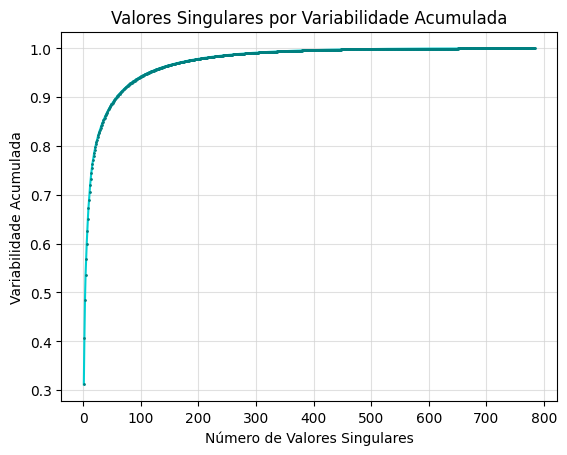

In [10]:
grafico_variabilidade(variabilidade, S)

In [11]:
results = []
times = []

In [12]:
porcentagem_variabilidade = 0.85

r = np.where(variabilidade >= porcentagem_variabilidade)[0][0] + 1
print(f'Número de valores singulares para atingir {porcentagem_variabilidade*100}% de variabilidade: {r}')
P_train, P_test = componentes_principais(r, Vt, train, test)
result1, current_time = knn(P_train, P_test, y_train_arr, y_test_arr)
results.append(result1)
times.append(current_time)
acuracia  = calcular_acuracia(y_test_arr, result1)
print(f'{acuracia}% de acrurácia')

Número de valores singulares para atingir 85.0% de variabilidade: 35
Tempo de execução: 0 horas, 50 minutos e 40.631661 segundos
81.12102621305075% de acrurácia


In [17]:
r = np.where(variabilidade >= 0.90)[0][0] + 1
print(f'Número de valores singulares para atingir {porcentagem_variabilidade*100}% de variabilidade: {r}')
P_train, P_test = componentes_principais(r, Vt, train, test)
result2, current_time = knn(P_train, P_test, y_train_arr, y_test_arr)
results.append(result2)
times.append(current_time)
acuracia  = calcular_acuracia(y_test_arr, result2)
print(f'{acuracia}% de acrurácia')

Número de valores singulares para atingir 85.0% de variabilidade: 58
Tempo de execução: 0 horas, 51 minutos e 54.191584 segundos
81.98549916341328% de acrurácia


In [18]:
r = np.where(variabilidade >= 0.95)[0][0] + 1
print(f'Número de valores singulares para atingir {95*100}% de variabilidade: {r}')
P_train, P_test = componentes_principais(r, Vt, train, test)
result3, current_time = knn(P_train, P_test, y_train_arr, y_test_arr)
results.append(result3)
times.append(current_time)
acuracia  = calcular_acuracia(y_test_arr, result3)
print(f'{acuracia}% de acrurácia')

Número de valores singulares para atingir 9500% de variabilidade: 113
Tempo de execução: 1 horas, 39 minutos e 50.686390 segundos
82.069157836029% de acrurácia


In [19]:
r = 300
P_train, P_test = componentes_principais(r, Vt, train, test)
result4, current_time = knn(P_train, P_test, y_train_arr, y_test_arr)
results.append(result4)
times.append(current_time)
acuracia  = calcular_acuracia(y_test_arr, result4)
print(f'{acuracia}% de acrurácia')

Tempo de execução: 4 horas, 34 minutos e 3.270220 segundos
81.23257110987171% de acrurácia


In [12]:
r = 400
P_train, P_test = componentes_principais(r, Vt, train, test)
result5, current_time = knn(P_train, P_test, y_train_arr, y_test_arr)
acuracia  = calcular_acuracia(y_test_arr, result5)
print(f'{acuracia}% de acrurácia')

Tempo de execução: 6 horas, 8 minutos e 24.570175 segundos
81.05131065253765% de acrurácia


In [13]:
r = 500
P_train, P_test = componentes_principais(r, Vt, train, test)
result5, current_time = knn(P_train, P_test, y_train_arr, y_test_arr)
acuracia  = calcular_acuracia(y_test_arr, result5)
print(f'{acuracia}% de acrurácia')

Tempo de execução: 7 horas, 25 minutos e 7.710999 segundos
81.00948131622978% de acrurácia


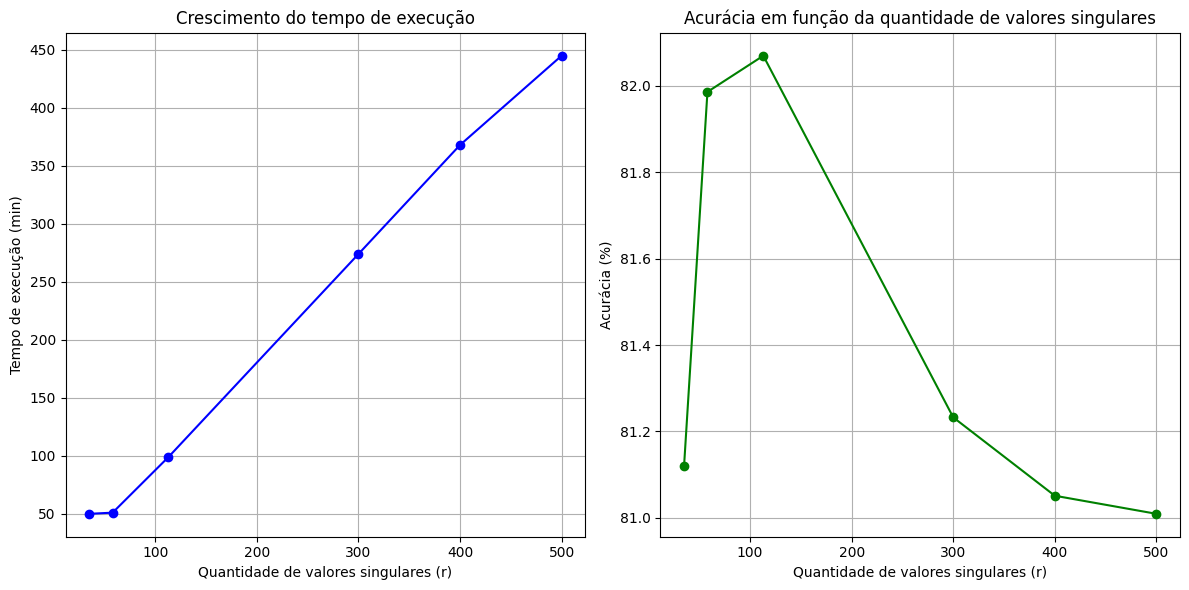

In [38]:
valores_r = [35, 58, 113, 300, 400, 500]
tempos = [50, 51, 99, 274, 368, 445] # tempo em minutos
acuracias = [81.12102621305075, 81.98549916341328, 82.069157836029, 81.23257110987171, 81.05131065253765, 81.00948131622978]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(valores_r, tempos, marker='o', linestyle='-', color='b')
plt.xlabel('Quantidade de valores singulares (r)')
plt.ylabel('Tempo de execução (min)')
plt.title('Crescimento do tempo de execução')
plt.grid(True)

# Plot da acurácia
plt.subplot(1, 2, 2)
plt.plot(valores_r, acuracias, marker='o', linestyle='-', color='g')
plt.xlabel('Quantidade de valores singulares (r)')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia em função da quantidade de valores singulares')
plt.grid(True)

plt.tight_layout()
plt.show()